In [1]:
# Deep convolutional generative adversarial network 
# Make this code multi GPU trainable
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transformation that needs to be applied on the input image 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), # this transforms the data between -1 and 1
])

BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

dataset = torchvision.datasets.MNIST(root='.', download=False, transform=transform)
loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=1)

In [2]:
batch = next(iter(loader))
print(batch[1])
print(batch[0].shape) # there are 64 images each of dimension 28X28 with just 1 channel
# print(batch[0])
unique_values = torch.unique(batch[0])
print(unique_values)

tensor([6, 2, 3, 1, 9, 1, 1, 6, 2, 3, 7, 0, 9, 2, 1, 3, 2, 6, 7, 8, 4, 0, 8, 3,
        6, 6, 9, 5, 1, 3, 7, 1, 8, 3, 6, 1, 4, 6, 6, 1, 3, 9, 8, 9, 6, 6, 8, 8,
        9, 9, 6, 0, 9, 3, 2, 6, 5, 0, 4, 7, 8, 2, 3, 3])
torch.Size([64, 1, 28, 28])
tensor([-1.0000, -0.9922, -0.9843, -0.9765, -0.9686, -0.9608, -0.9529, -0.9451,
        -0.9373, -0.9294, -0.9216, -0.9137, -0.9059, -0.8980, -0.8902, -0.8824,
        -0.8745, -0.8667, -0.8588, -0.8510, -0.8431, -0.8353, -0.8275, -0.8196,
        -0.8118, -0.8039, -0.7961, -0.7882, -0.7804, -0.7725, -0.7647, -0.7569,
        -0.7490, -0.7412, -0.7333, -0.7255, -0.7176, -0.7098, -0.7020, -0.6941,
        -0.6863, -0.6784, -0.6706, -0.6627, -0.6549, -0.6471, -0.6392, -0.6314,
        -0.6235, -0.6157, -0.6078, -0.6000, -0.5922, -0.5843, -0.5765, -0.5686,
        -0.5608, -0.5529, -0.5451, -0.5373, -0.5294, -0.5216, -0.5137, -0.5059,
        -0.4980, -0.4902, -0.4824, -0.4745, -0.4667, -0.4588, -0.4510, -0.4431,
        -0.4353, -0.4275, -0.4196, 

In [9]:
from tqdm.auto import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
# The generator will be composed of a series of 2d transpose convolutions - upsampling
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_channels=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            self.make_generator_layer(z_dim, hidden_dim*4),
            self.make_generator_layer(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.make_generator_layer(hidden_dim*2, hidden_dim),
            self.make_generator_layer(hidden_dim, im_channels, kernel_size=4, final_layer=True)
        )
        
    def forward(self, noise):
        # print(f'Noise shape inside the generator : {noise.shape}')
        return self.generator(noise)
        
    def make_generator_layer(self, in_channels, out_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride),
                nn.Tanh() # returns a pixel value between -1 and 1
            )
        
    def sample_noise(self, batch_size=BATCH_SIZE, z_dim=10, device=device):
        return torch.randn(batch_size, z_dim).to(device)

In [4]:
gen = Generator().to(device)
noise = gen.sample_noise()
# unsqueeze the noise 
noise = noise.view(len(noise), 10, 1, 1)
out = gen(noise)
print(out.shape) # batch size of 16, each image is of dimension 28x28 and has 1 channel

torch.Size([64, 1, 28, 28])


In [5]:
# The discriminator will be composed of 2d convolution operations - downsampling
# downsampling reduces the dimension and increases the number of channels in the image
class Discriminator(nn.Module):
    def __init__(self, im_channels=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            self.make_disc_layer(im_channels, hidden_dim),
            self.make_disc_layer(hidden_dim, hidden_dim*2),
            self.make_disc_layer(hidden_dim*2, 1, final_layer=True)
        )
        
    def forward(self, image):
        disc_pred = self.discriminator(image)
        return disc_pred.view(len(disc_pred), -1)
        
    def make_disc_layer(self, in_channels, out_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True) # saves memory doing it inplace, doesn't generate a new output
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride) # no activation required for the final layer
            )

In [6]:
disc = Discriminator().to(device)
image = torch.randn(BATCH_SIZE, 1, 28, 28).to(device)
classification = disc(image)
print(classification.shape)

# this generates a single classification score for all the imags in the batch
# we can integrate a patch based discriminator loss which generates a fake/real classification score for every patch of the image 

torch.Size([64, 1])


In [14]:
import torch.optim as optim

z_dim = 64
beta_1 = 0.5
beta_2 = 0.999
lr = 2e-4
epochs = 100

# binary classification loss for fake and real image
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)
criterion = nn.BCEWithLogitsLoss()
gen_opt = optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_opt = optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
# Weight initialization is really important
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Epoch : 0, step : 200, mean gen loss : 0.6901419702172277, mean disc loss : 0.6509570938348773
Epoch : 0, step : 400, mean gen loss : 0.8670021903514854, mean disc loss : 0.51434770911932
Epoch : 0, step : 600, mean gen loss : 1.3836379885673535, mean disc loss : 0.30239017702639104
Epoch : 0, step : 800, mean gen loss : 2.082951054573059, mean disc loss : 0.17235892921686166


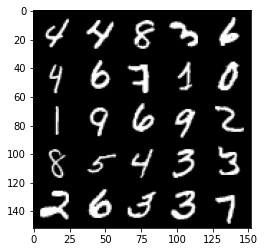

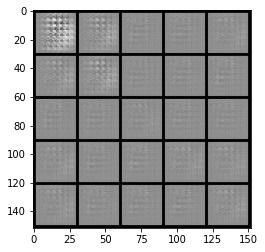

Epoch : 1, step : 1000, mean gen loss : 2.696748073101042, mean disc loss : 0.0866295727528632
Epoch : 1, step : 1200, mean gen loss : 3.083139723539353, mean disc loss : 0.056592151578515784
Epoch : 1, step : 1400, mean gen loss : 2.4323865775391464, mean disc loss : 0.27463070951402185
Epoch : 1, step : 1600, mean gen loss : 1.9198107144981618, mean disc loss : 0.3396031379699706
Epoch : 1, step : 1800, mean gen loss : 1.4791183753311647, mean disc loss : 0.45785018295049673


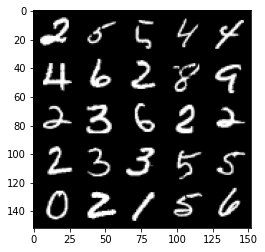

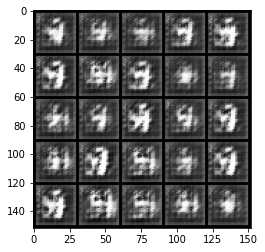

Epoch : 2, step : 2000, mean gen loss : 1.6936925981938846, mean disc loss : 0.3638320651277901
Epoch : 2, step : 2200, mean gen loss : 1.2736143443733463, mean disc loss : 0.4951343606412408
Epoch : 2, step : 2400, mean gen loss : 1.1734493070095773, mean disc loss : 0.5197875124216078
Epoch : 2, step : 2600, mean gen loss : 1.1527914279699332, mean disc loss : 0.4877687545120713
Epoch : 2, step : 2800, mean gen loss : 1.0703970342874527, mean disc loss : 0.5286917945742607


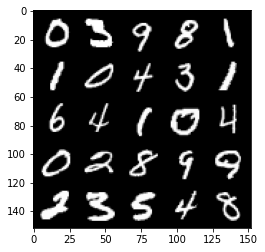

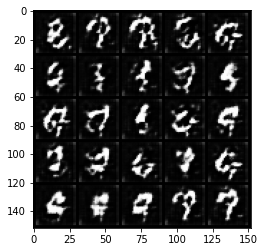

Epoch : 3, step : 3000, mean gen loss : 1.024783164709806, mean disc loss : 0.5434296049177649
Epoch : 3, step : 3200, mean gen loss : 0.9576337566971779, mean disc loss : 0.5717364647984506
Epoch : 3, step : 3400, mean gen loss : 0.8745059956610196, mean disc loss : 0.6014665934443475
Epoch : 3, step : 3600, mean gen loss : 0.8521017645299431, mean disc loss : 0.6205459892749785


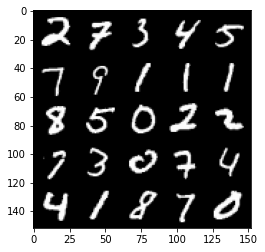

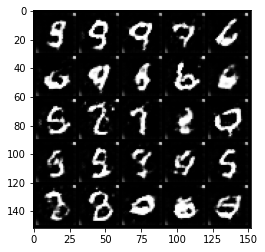

Epoch : 4, step : 3800, mean gen loss : 0.8245662382245067, mean disc loss : 0.6198610317707062
Epoch : 4, step : 4000, mean gen loss : 0.8298069056868549, mean disc loss : 0.6200379198789594
Epoch : 4, step : 4200, mean gen loss : 0.8435518935322764, mean disc loss : 0.6327704751491541
Epoch : 4, step : 4400, mean gen loss : 0.8234829115867616, mean disc loss : 0.6307994484901422
Epoch : 4, step : 4600, mean gen loss : 0.8144311800599103, mean disc loss : 0.6490228140354154


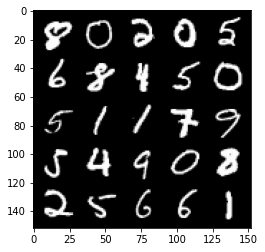

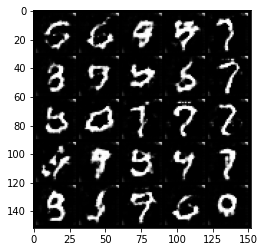

Epoch : 5, step : 4800, mean gen loss : 0.8332403260469433, mean disc loss : 0.643460359275341
Epoch : 5, step : 5000, mean gen loss : 0.8294136205315586, mean disc loss : 0.6444087719917297
Epoch : 5, step : 5200, mean gen loss : 0.7998629042506218, mean disc loss : 0.6474917158484459
Epoch : 5, step : 5400, mean gen loss : 0.8035447566211226, mean disc loss : 0.6597391897439956
Epoch : 5, step : 5600, mean gen loss : 0.7936580626666545, mean disc loss : 0.664088174402714


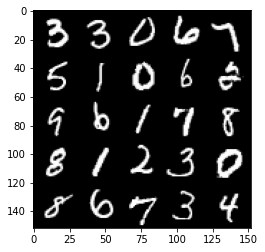

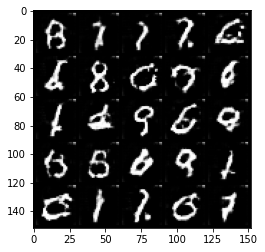

Epoch : 6, step : 5800, mean gen loss : 0.7879842692613599, mean disc loss : 0.6621891146898264
Epoch : 6, step : 6000, mean gen loss : 0.7761377307772641, mean disc loss : 0.6655870419740674
Epoch : 6, step : 6200, mean gen loss : 0.7696802362799642, mean disc loss : 0.6703481221199035
Epoch : 6, step : 6400, mean gen loss : 0.7717136394977573, mean disc loss : 0.670060593187809


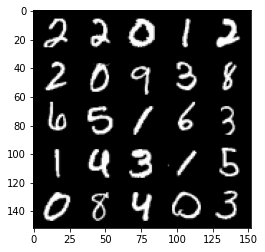

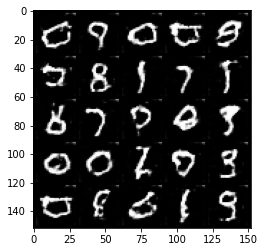

Epoch : 7, step : 6600, mean gen loss : 0.7706324744224546, mean disc loss : 0.6746230161190034
Epoch : 7, step : 6800, mean gen loss : 0.7574868911504745, mean disc loss : 0.6725637423992156
Epoch : 7, step : 7000, mean gen loss : 0.7625463560223581, mean disc loss : 0.6788235169649122
Epoch : 7, step : 7200, mean gen loss : 0.7618407906591891, mean disc loss : 0.679321069121361
Epoch : 7, step : 7400, mean gen loss : 0.7455601577460771, mean disc loss : 0.6900237688422204


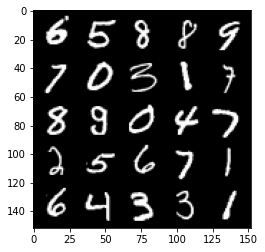

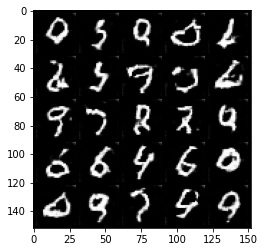

Epoch : 8, step : 7600, mean gen loss : 0.7391511449217798, mean disc loss : 0.6810599729418755
Epoch : 8, step : 7800, mean gen loss : 0.7622585864365101, mean disc loss : 0.6801595103740687
Epoch : 8, step : 8000, mean gen loss : 0.7549821390211581, mean disc loss : 0.6796456125378606
Epoch : 8, step : 8200, mean gen loss : 0.7571050168573857, mean disc loss : 0.6825492665171626
Epoch : 8, step : 8400, mean gen loss : 0.7455690874159335, mean disc loss : 0.684790000617504


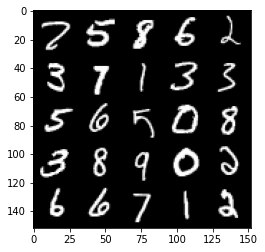

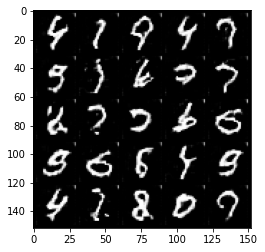

Epoch : 9, step : 8600, mean gen loss : 0.7455030679702759, mean disc loss : 0.6855989131331444
Epoch : 9, step : 8800, mean gen loss : 0.7431329435110096, mean disc loss : 0.6883646056056023
Epoch : 9, step : 9000, mean gen loss : 0.7338376952707767, mean disc loss : 0.6899992918968202
Epoch : 9, step : 9200, mean gen loss : 0.7337421098351479, mean disc loss : 0.6883419468998908


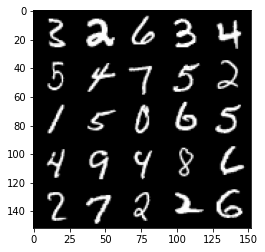

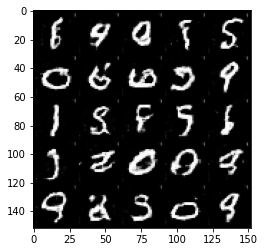

Epoch : 10, step : 9400, mean gen loss : 0.7374685764312744, mean disc loss : 0.6908681535720821
Epoch : 10, step : 9600, mean gen loss : 0.7293588927388195, mean disc loss : 0.6885891160368917
Epoch : 10, step : 9800, mean gen loss : 0.7271311187744143, mean disc loss : 0.6902478381991379
Epoch : 10, step : 10000, mean gen loss : 0.7265336309373379, mean disc loss : 0.6903383082151413
Epoch : 10, step : 10200, mean gen loss : 0.7235639835894102, mean disc loss : 0.6943320479989048


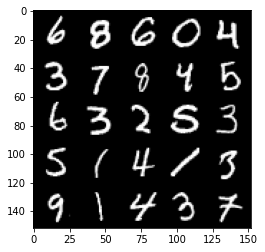

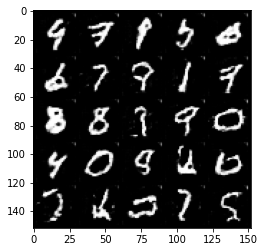

Epoch : 11, step : 10400, mean gen loss : 0.7315899080038072, mean disc loss : 0.6898126050829887
Epoch : 11, step : 10600, mean gen loss : 0.7273815843462943, mean disc loss : 0.691656166911125
Epoch : 11, step : 10800, mean gen loss : 0.7225422874093056, mean disc loss : 0.6925005841255186
Epoch : 11, step : 11000, mean gen loss : 0.72908614680171, mean disc loss : 0.6945474585890773
Epoch : 11, step : 11200, mean gen loss : 0.7221022795140744, mean disc loss : 0.6932857903838153


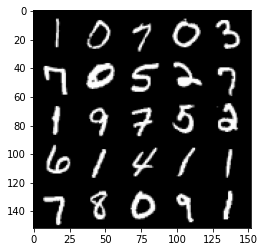

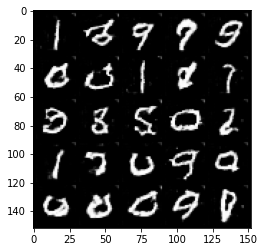

Epoch : 12, step : 11400, mean gen loss : 0.7225608749687669, mean disc loss : 0.6946871656179431
Epoch : 12, step : 11600, mean gen loss : 0.7168022722005847, mean disc loss : 0.6940017896890641
Epoch : 12, step : 11800, mean gen loss : 0.7197683912515638, mean disc loss : 0.6947533196210864
Epoch : 12, step : 12000, mean gen loss : 0.7201648980379107, mean disc loss : 0.695917655825615


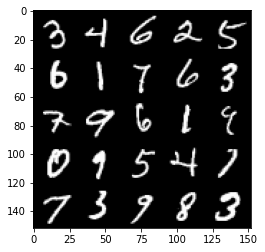

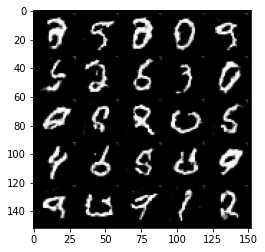

Epoch : 13, step : 12200, mean gen loss : 0.7201102612912658, mean disc loss : 0.6961993345618253
Epoch : 13, step : 12400, mean gen loss : 0.7128420105576513, mean disc loss : 0.6958522450923922
Epoch : 13, step : 12600, mean gen loss : 0.7121046409010888, mean disc loss : 0.6960828083753586
Epoch : 13, step : 12800, mean gen loss : 0.7137452143430711, mean disc loss : 0.6970659250020982
Epoch : 13, step : 13000, mean gen loss : 0.717017566114664, mean disc loss : 0.6961454874277114


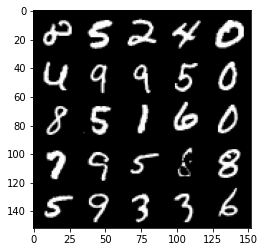

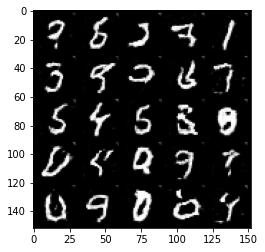

Epoch : 14, step : 13200, mean gen loss : 0.7094499579071998, mean disc loss : 0.6994541561603544
Epoch : 14, step : 13400, mean gen loss : 0.7113883447647097, mean disc loss : 0.6968924140930175
Epoch : 14, step : 13600, mean gen loss : 0.7115793631970883, mean disc loss : 0.6958628249168392
Epoch : 14, step : 13800, mean gen loss : 0.7107306450605388, mean disc loss : 0.6958166915178301
Epoch : 14, step : 14000, mean gen loss : 0.7100844168663026, mean disc loss : 0.6953193762898444


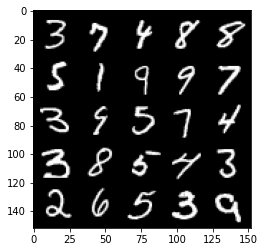

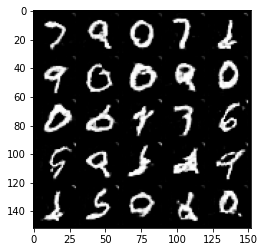

Epoch : 15, step : 14200, mean gen loss : 0.7102976937592032, mean disc loss : 0.6965460842847825
Epoch : 15, step : 14400, mean gen loss : 0.710104797333479, mean disc loss : 0.6969714254140854
Epoch : 15, step : 14600, mean gen loss : 0.709167289286852, mean disc loss : 0.6966378647089003
Epoch : 15, step : 14800, mean gen loss : 0.7097716438770296, mean disc loss : 0.6958020129799839
Epoch : 15, step : 15000, mean gen loss : 0.7071689978241921, mean disc loss : 0.6972506698966023


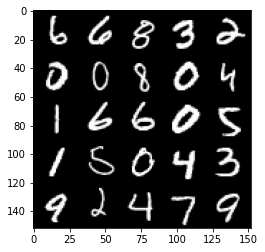

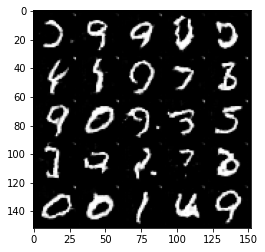

Epoch : 16, step : 15200, mean gen loss : 0.7078353835642335, mean disc loss : 0.6959140115976334
Epoch : 16, step : 15400, mean gen loss : 0.7068948461115361, mean disc loss : 0.6966588839888571
Epoch : 16, step : 15600, mean gen loss : 0.7064743840694425, mean disc loss : 0.6970957794785502
Epoch : 16, step : 15800, mean gen loss : 0.7041920369863506, mean disc loss : 0.6968787816166878


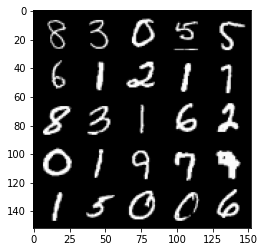

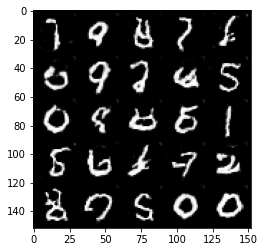

Epoch : 17, step : 16000, mean gen loss : 0.7069330510497088, mean disc loss : 0.696570248305797
Epoch : 17, step : 16200, mean gen loss : 0.7059554469585414, mean disc loss : 0.6968323713541029
Epoch : 17, step : 16400, mean gen loss : 0.7059872123599054, mean disc loss : 0.6977008822560309
Epoch : 17, step : 16600, mean gen loss : 0.7041835618019108, mean disc loss : 0.6972866097092624
Epoch : 17, step : 16800, mean gen loss : 0.7034733733534811, mean disc loss : 0.6974603837728501


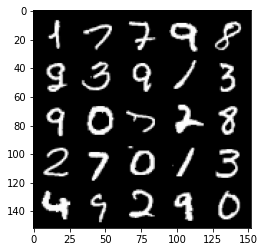

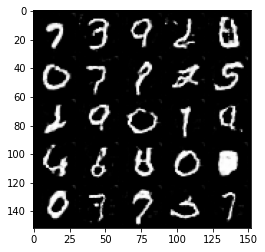

Epoch : 18, step : 17000, mean gen loss : 0.7016538180410863, mean disc loss : 0.697020652592182
Epoch : 18, step : 17200, mean gen loss : 0.7054374778270722, mean disc loss : 0.6973672509193416
Epoch : 18, step : 17400, mean gen loss : 0.7036911983788017, mean disc loss : 0.6978625762462624
Epoch : 18, step : 17600, mean gen loss : 0.7026726326346397, mean disc loss : 0.6968188107013707
Epoch : 18, step : 17800, mean gen loss : 0.7027130909264088, mean disc loss : 0.6976158243417739


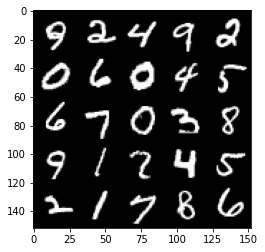

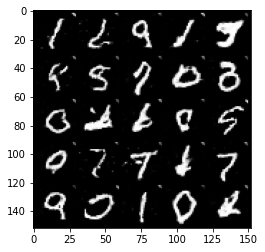

Epoch : 19, step : 18000, mean gen loss : 0.703370428979397, mean disc loss : 0.6980476355552674
Epoch : 19, step : 18200, mean gen loss : 0.7008235490322114, mean disc loss : 0.6986149096488955
Epoch : 19, step : 18400, mean gen loss : 0.7005234575271608, mean disc loss : 0.6970464354753496
Epoch : 19, step : 18600, mean gen loss : 0.7020851165056227, mean disc loss : 0.6970796886086459


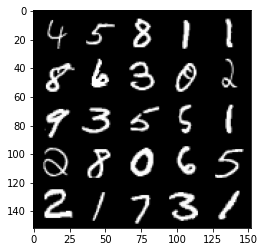

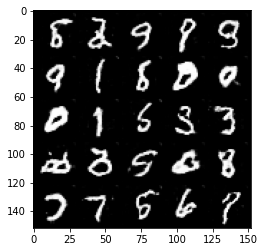

Epoch : 20, step : 18800, mean gen loss : 0.6992796099185946, mean disc loss : 0.6975919476151464
Epoch : 20, step : 19000, mean gen loss : 0.6983995234966276, mean disc loss : 0.697043292224407
Epoch : 20, step : 19200, mean gen loss : 0.702346502840519, mean disc loss : 0.6975828802585601
Epoch : 20, step : 19400, mean gen loss : 0.7008348816633223, mean disc loss : 0.697714082002639
Epoch : 20, step : 19600, mean gen loss : 0.6992753177881237, mean disc loss : 0.6974862968921663


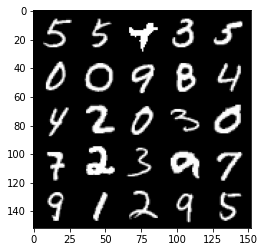

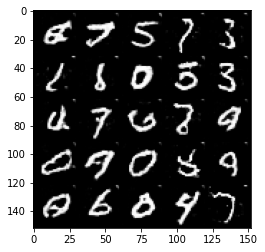

Epoch : 21, step : 19800, mean gen loss : 0.7009774586558336, mean disc loss : 0.6974663379788396
Epoch : 21, step : 20000, mean gen loss : 0.6990066421031954, mean disc loss : 0.6970685157179836
Epoch : 21, step : 20200, mean gen loss : 0.7007450726628305, mean disc loss : 0.6966179433465002
Epoch : 21, step : 20400, mean gen loss : 0.6994009223580363, mean disc loss : 0.6965072575211524
Epoch : 21, step : 20600, mean gen loss : 0.6998691099882128, mean disc loss : 0.6979507654905317


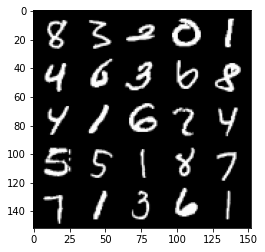

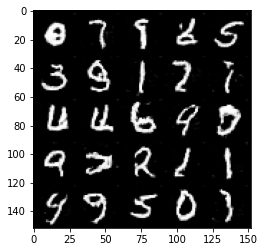

Epoch : 22, step : 20800, mean gen loss : 0.7014984250068657, mean disc loss : 0.6972468847036362
Epoch : 22, step : 21000, mean gen loss : 0.69915872246027, mean disc loss : 0.6970621481537819
Epoch : 22, step : 21200, mean gen loss : 0.6991535314917567, mean disc loss : 0.6966755986213682
Epoch : 22, step : 21400, mean gen loss : 0.6983778342604637, mean disc loss : 0.6962819421291355


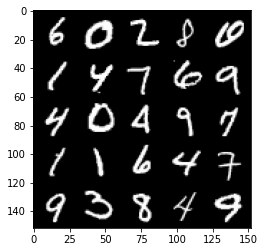

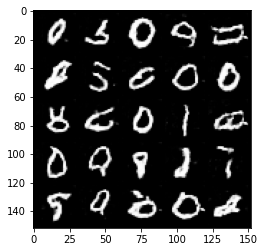

Epoch : 23, step : 21600, mean gen loss : 0.6985688069462775, mean disc loss : 0.6966740709543227
Epoch : 23, step : 21800, mean gen loss : 0.6991690048575402, mean disc loss : 0.6971574664115909
Epoch : 23, step : 22000, mean gen loss : 0.6999290341138844, mean disc loss : 0.6968755534291267
Epoch : 23, step : 22200, mean gen loss : 0.697628635466099, mean disc loss : 0.6973617568612099
Epoch : 23, step : 22400, mean gen loss : 0.7007247027754784, mean disc loss : 0.6963842526078226


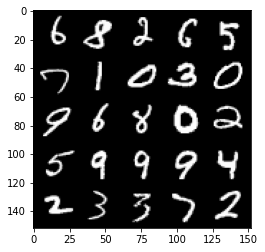

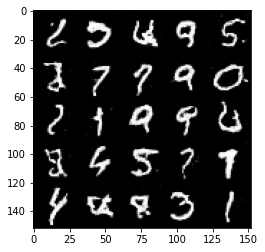

Epoch : 24, step : 22600, mean gen loss : 0.6968003070354459, mean disc loss : 0.6971475523710253
Epoch : 24, step : 22800, mean gen loss : 0.6980545684695241, mean disc loss : 0.6975589132308956
Epoch : 24, step : 23000, mean gen loss : 0.6989494952559471, mean disc loss : 0.6966124823689459
Epoch : 24, step : 23200, mean gen loss : 0.6980447208881377, mean disc loss : 0.696648499965668
Epoch : 24, step : 23400, mean gen loss : 0.6985706850886348, mean disc loss : 0.696583406925202


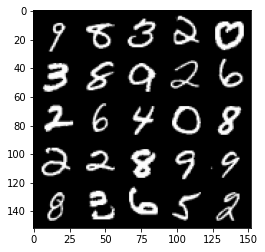

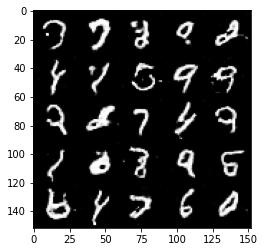

Epoch : 25, step : 23600, mean gen loss : 0.6961302873492236, mean disc loss : 0.6958079180121429
Epoch : 25, step : 23800, mean gen loss : 0.6981026065349576, mean disc loss : 0.6968864494562149
Epoch : 25, step : 24000, mean gen loss : 0.6964474052190778, mean disc loss : 0.6962658095359806
Epoch : 25, step : 24200, mean gen loss : 0.6961929464340212, mean disc loss : 0.6974156892299653


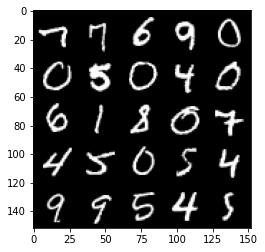

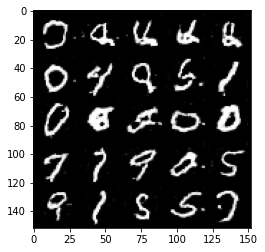

Epoch : 26, step : 24400, mean gen loss : 0.6964224550127986, mean disc loss : 0.6965516394376755
Epoch : 26, step : 24600, mean gen loss : 0.6963926348090174, mean disc loss : 0.6965252882242207
Epoch : 26, step : 24800, mean gen loss : 0.6978457832336425, mean disc loss : 0.6964287054538723
Epoch : 26, step : 25000, mean gen loss : 0.6984225869178775, mean disc loss : 0.696313260495663
Epoch : 26, step : 25200, mean gen loss : 0.6965698218345641, mean disc loss : 0.6960245224833487


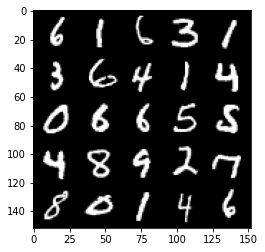

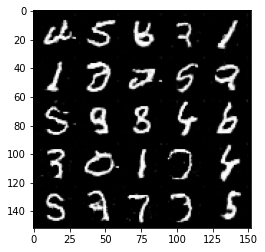

Epoch : 27, step : 25400, mean gen loss : 0.6967911246418951, mean disc loss : 0.6967605432868003
Epoch : 27, step : 25600, mean gen loss : 0.6954571521282198, mean disc loss : 0.6963820239901539
Epoch : 27, step : 25800, mean gen loss : 0.6995635274052618, mean disc loss : 0.6963213708996775
Epoch : 27, step : 26000, mean gen loss : 0.6972031623125075, mean disc loss : 0.6960630866885191
Epoch : 27, step : 26200, mean gen loss : 0.6962149524688723, mean disc loss : 0.6961241832375528


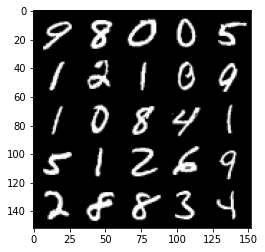

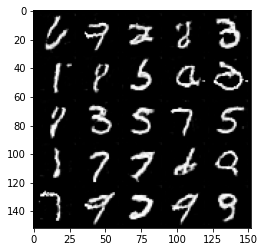

Epoch : 28, step : 26400, mean gen loss : 0.6958548045158384, mean disc loss : 0.6969067889451975
Epoch : 28, step : 26600, mean gen loss : 0.6972177442908292, mean disc loss : 0.6959300750494004
Epoch : 28, step : 26800, mean gen loss : 0.6965231537818909, mean disc loss : 0.6960470911860465
Epoch : 28, step : 27000, mean gen loss : 0.695513070225716, mean disc loss : 0.6961647000908849
Epoch : 28, step : 27200, mean gen loss : 0.6955803105235102, mean disc loss : 0.6958876770734789


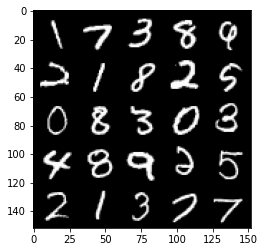

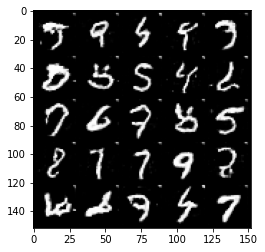

Epoch : 29, step : 27400, mean gen loss : 0.6976234412193298, mean disc loss : 0.6960508567094806
Epoch : 29, step : 27600, mean gen loss : 0.6950681108236311, mean disc loss : 0.6961841022968296
Epoch : 29, step : 27800, mean gen loss : 0.6981387734413149, mean disc loss : 0.6960288459062577
Epoch : 29, step : 28000, mean gen loss : 0.6938389953970909, mean disc loss : 0.6963622722029684


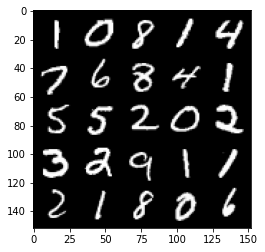

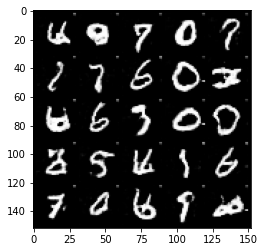

Epoch : 30, step : 28200, mean gen loss : 0.6958594927191731, mean disc loss : 0.6956084698438644
Epoch : 30, step : 28400, mean gen loss : 0.6956282237172124, mean disc loss : 0.6956450930237764
Epoch : 30, step : 28600, mean gen loss : 0.6953894671797753, mean disc loss : 0.6954351016879083
Epoch : 30, step : 28800, mean gen loss : 0.6966371089220046, mean disc loss : 0.6957429215312003
Epoch : 30, step : 29000, mean gen loss : 0.6951636034250261, mean disc loss : 0.6955925685167317


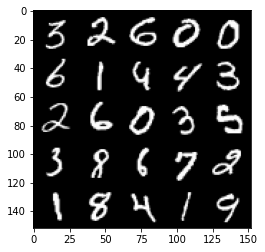

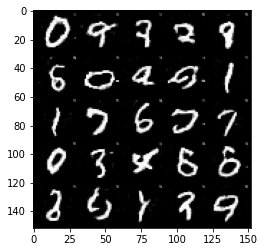

Epoch : 31, step : 29200, mean gen loss : 0.694728181362152, mean disc loss : 0.695395952165127
Epoch : 31, step : 29400, mean gen loss : 0.6960785219073297, mean disc loss : 0.6955165341496466
Epoch : 31, step : 29600, mean gen loss : 0.6946662861108773, mean disc loss : 0.6952560582756998
Epoch : 31, step : 29800, mean gen loss : 0.6954187369346616, mean disc loss : 0.6954875364899639
Epoch : 31, step : 30000, mean gen loss : 0.6949839124083514, mean disc loss : 0.695339452922344


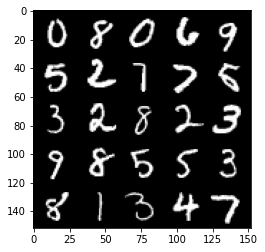

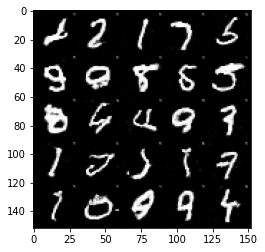

Epoch : 32, step : 30200, mean gen loss : 0.6961319953203203, mean disc loss : 0.6955878821015361
Epoch : 32, step : 30400, mean gen loss : 0.6971238803863524, mean disc loss : 0.6953624227643016
Epoch : 32, step : 30600, mean gen loss : 0.6943996199965484, mean disc loss : 0.6953377091884614
Epoch : 32, step : 30800, mean gen loss : 0.6943785715103149, mean disc loss : 0.6956985190510745


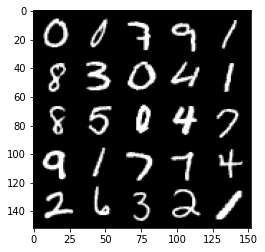

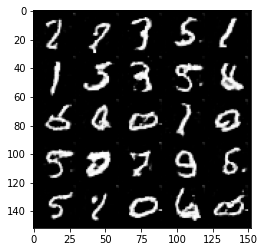

Epoch : 33, step : 31000, mean gen loss : 0.6958119165897375, mean disc loss : 0.6951799288392069
Epoch : 33, step : 31200, mean gen loss : 0.6943376788496969, mean disc loss : 0.6951754423975944
Epoch : 33, step : 31400, mean gen loss : 0.6956231760978699, mean disc loss : 0.6951893836259843
Epoch : 33, step : 31600, mean gen loss : 0.6954981309175489, mean disc loss : 0.6952943584322928
Epoch : 33, step : 31800, mean gen loss : 0.6950878733396529, mean disc loss : 0.6953510695695883


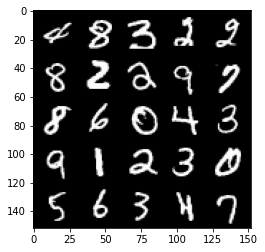

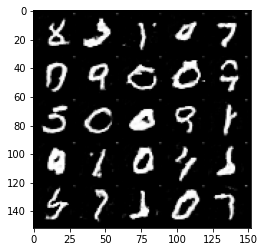

Epoch : 34, step : 32000, mean gen loss : 0.6972168618440626, mean disc loss : 0.6949152502417559
Epoch : 34, step : 32200, mean gen loss : 0.696181109845638, mean disc loss : 0.6952194312214848
Epoch : 34, step : 32400, mean gen loss : 0.694597621560097, mean disc loss : 0.6951930457353588
Epoch : 34, step : 32600, mean gen loss : 0.6967210766673084, mean disc loss : 0.6951802775263787
Epoch : 34, step : 32800, mean gen loss : 0.6967007890343664, mean disc loss : 0.6949363493919376


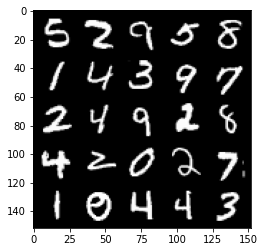

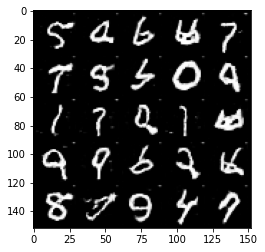

Epoch : 35, step : 33000, mean gen loss : 0.6954258501529692, mean disc loss : 0.6948174715042115
Epoch : 35, step : 33200, mean gen loss : 0.6930013939738275, mean disc loss : 0.6948735180497171
Epoch : 35, step : 33400, mean gen loss : 0.6940197414159776, mean disc loss : 0.6949317258596417
Epoch : 35, step : 33600, mean gen loss : 0.6942400741577153, mean disc loss : 0.6949092879891395


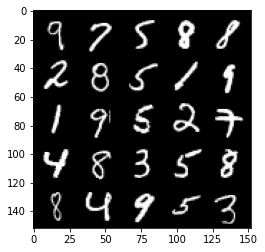

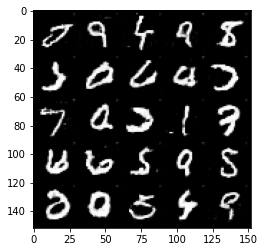

Epoch : 36, step : 33800, mean gen loss : 0.6955232650041583, mean disc loss : 0.695095987021923
Epoch : 36, step : 34000, mean gen loss : 0.6948076659440996, mean disc loss : 0.6946410083770757
Epoch : 36, step : 34200, mean gen loss : 0.6950865799188616, mean disc loss : 0.6947270154953005
Epoch : 36, step : 34400, mean gen loss : 0.6960475969314575, mean disc loss : 0.6944900822639465
Epoch : 36, step : 34600, mean gen loss : 0.6959145262837413, mean disc loss : 0.694893383085728


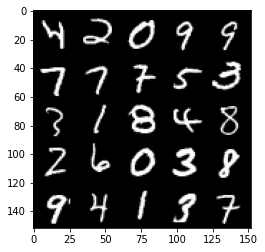

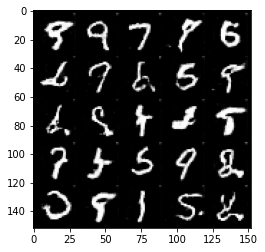

Epoch : 37, step : 34800, mean gen loss : 0.6946680521965025, mean disc loss : 0.6947441905736925
Epoch : 37, step : 35000, mean gen loss : 0.695380056500435, mean disc loss : 0.6946487194299695
Epoch : 37, step : 35200, mean gen loss : 0.694423568248749, mean disc loss : 0.6945303985476493
Epoch : 37, step : 35400, mean gen loss : 0.6956936728954318, mean disc loss : 0.6941937887668609
Epoch : 37, step : 35600, mean gen loss : 0.6949844139814374, mean disc loss : 0.6947545292973519


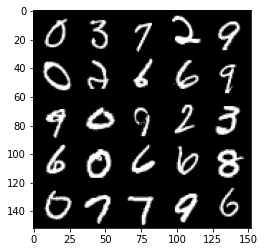

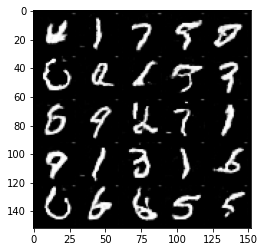

Epoch : 38, step : 35800, mean gen loss : 0.6945327278971674, mean disc loss : 0.6944262173771856
Epoch : 38, step : 36000, mean gen loss : 0.6945574992895129, mean disc loss : 0.6944928398728369
Epoch : 38, step : 36200, mean gen loss : 0.6946811512112615, mean disc loss : 0.6943978229165074
Epoch : 38, step : 36400, mean gen loss : 0.696774650216102, mean disc loss : 0.6946070280671125


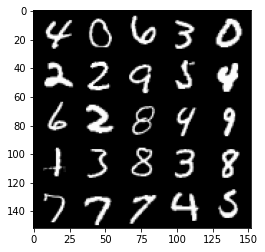

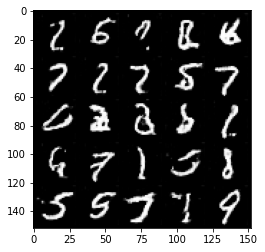

Epoch : 39, step : 36600, mean gen loss : 0.6954480633139611, mean disc loss : 0.6945459410548213
Epoch : 39, step : 36800, mean gen loss : 0.6953511178493498, mean disc loss : 0.6942001220583915
Epoch : 39, step : 37000, mean gen loss : 0.6963916397094728, mean disc loss : 0.6945940840244295
Epoch : 39, step : 37200, mean gen loss : 0.6953343692421915, mean disc loss : 0.694605314731598
Epoch : 39, step : 37400, mean gen loss : 0.6948563149571418, mean disc loss : 0.6941826233267782


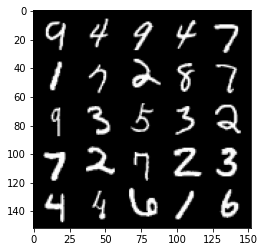

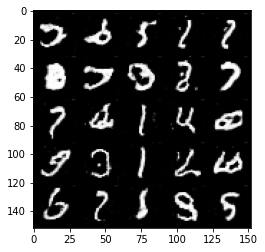

Epoch : 40, step : 37600, mean gen loss : 0.6943683925271033, mean disc loss : 0.6943583974242212
Epoch : 40, step : 37800, mean gen loss : 0.6950070080161097, mean disc loss : 0.6942399168014528
Epoch : 40, step : 38000, mean gen loss : 0.6941924452781673, mean disc loss : 0.6941951245069505
Epoch : 40, step : 38200, mean gen loss : 0.6962277382612225, mean disc loss : 0.6939961689710625
Epoch : 40, step : 38400, mean gen loss : 0.6940041410923004, mean disc loss : 0.6941696593165398


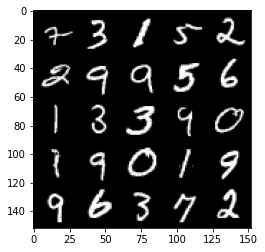

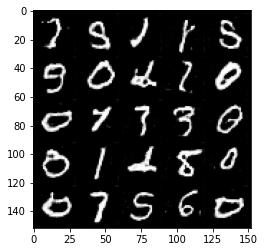

Epoch : 41, step : 38600, mean gen loss : 0.6940908408164982, mean disc loss : 0.6942333111166952
Epoch : 41, step : 38800, mean gen loss : 0.6958427321910857, mean disc loss : 0.6939184951782225
Epoch : 41, step : 39000, mean gen loss : 0.6948803755640983, mean disc loss : 0.6941388890147213
Epoch : 41, step : 39200, mean gen loss : 0.6947944593429565, mean disc loss : 0.6940397685766221


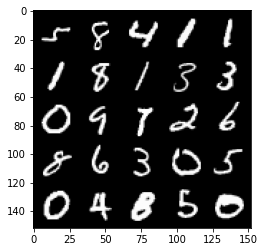

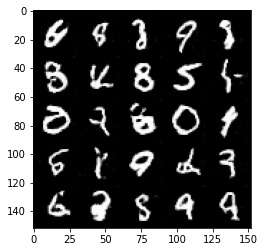

Epoch : 42, step : 39400, mean gen loss : 0.6953921809792518, mean disc loss : 0.694327485859394
Epoch : 42, step : 39600, mean gen loss : 0.6948021581768986, mean disc loss : 0.6938735586404798
Epoch : 42, step : 39800, mean gen loss : 0.6940213206410403, mean disc loss : 0.6941792991757392
Epoch : 42, step : 40000, mean gen loss : 0.6948480722308163, mean disc loss : 0.6943247565627095
Epoch : 42, step : 40200, mean gen loss : 0.6949933186173438, mean disc loss : 0.6941276928782467


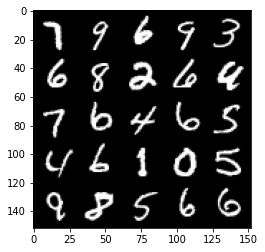

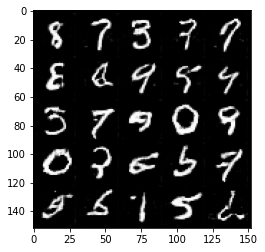

Epoch : 43, step : 40400, mean gen loss : 0.6950588262081147, mean disc loss : 0.6942329514026648
Epoch : 43, step : 40600, mean gen loss : 0.6951761418581008, mean disc loss : 0.6939614510536201
Epoch : 43, step : 40800, mean gen loss : 0.6947576650977138, mean disc loss : 0.6940306752920153
Epoch : 43, step : 41000, mean gen loss : 0.693659456074238, mean disc loss : 0.6940931978821757
Epoch : 43, step : 41200, mean gen loss : 0.6942818251252177, mean disc loss : 0.6940433967113493


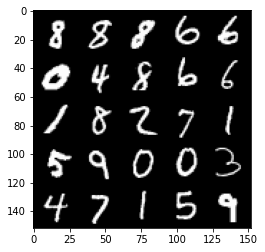

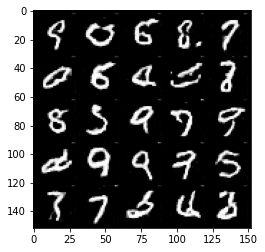

Epoch : 44, step : 41400, mean gen loss : 0.6944756412506103, mean disc loss : 0.6939893558621406
Epoch : 44, step : 41600, mean gen loss : 0.6967610317468644, mean disc loss : 0.69415553689003
Epoch : 44, step : 41800, mean gen loss : 0.6933607700467109, mean disc loss : 0.6942294794321058
Epoch : 44, step : 42000, mean gen loss : 0.6950983780622481, mean disc loss : 0.6940852856636047
Epoch : 44, step : 42200, mean gen loss : 0.6942131236195562, mean disc loss : 0.6941397497057915


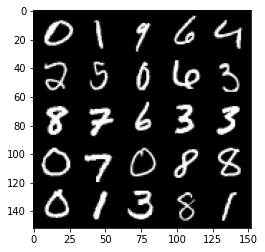

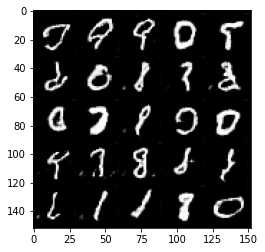

Epoch : 45, step : 42400, mean gen loss : 0.6943501353263853, mean disc loss : 0.6940894272923469
Epoch : 45, step : 42600, mean gen loss : 0.6947591245174413, mean disc loss : 0.6939666730165476
Epoch : 45, step : 42800, mean gen loss : 0.6970217320322991, mean disc loss : 0.6940130561590192
Epoch : 45, step : 43000, mean gen loss : 0.6949163067340846, mean disc loss : 0.6940536502003674


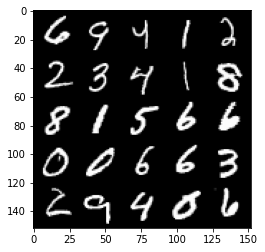

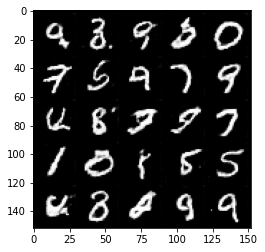

Epoch : 46, step : 43200, mean gen loss : 0.6940199592709543, mean disc loss : 0.6937724515795709
Epoch : 46, step : 43400, mean gen loss : 0.6937023949623106, mean disc loss : 0.6937871301174163
Epoch : 46, step : 43600, mean gen loss : 0.6943041089177133, mean disc loss : 0.6939354148507119
Epoch : 46, step : 43800, mean gen loss : 0.6942355442047118, mean disc loss : 0.6938835141062732
Epoch : 46, step : 44000, mean gen loss : 0.6931042054295538, mean disc loss : 0.6937993350625039


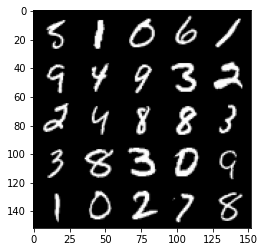

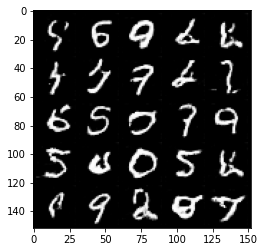

Epoch : 47, step : 44200, mean gen loss : 0.6953452992439272, mean disc loss : 0.6938614228367803
Epoch : 47, step : 44400, mean gen loss : 0.6948126325011256, mean disc loss : 0.693979774713516
Epoch : 47, step : 44600, mean gen loss : 0.6944387695193293, mean disc loss : 0.6939061468839646
Epoch : 47, step : 44800, mean gen loss : 0.6947817027568814, mean disc loss : 0.6938979884982107
Epoch : 47, step : 45000, mean gen loss : 0.6937085711956021, mean disc loss : 0.6938872873783108


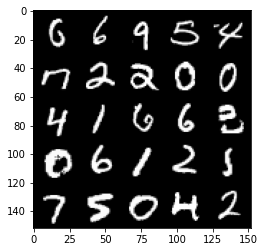

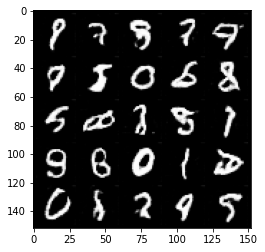

Epoch : 48, step : 45200, mean gen loss : 0.6944674262404442, mean disc loss : 0.6938792511820795
Epoch : 48, step : 45400, mean gen loss : 0.6934341904520992, mean disc loss : 0.6938011199235915
Epoch : 48, step : 45600, mean gen loss : 0.6935840347409248, mean disc loss : 0.6937722098827361
Epoch : 48, step : 45800, mean gen loss : 0.6935216927528386, mean disc loss : 0.6938388246297833


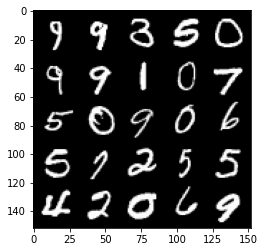

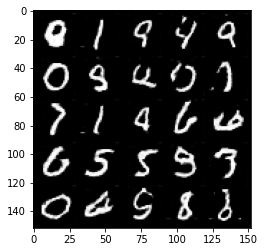

Epoch : 49, step : 46000, mean gen loss : 0.695810354948044, mean disc loss : 0.693867025077343
Epoch : 49, step : 46200, mean gen loss : 0.6951616281270981, mean disc loss : 0.6940666368603707
Epoch : 49, step : 46400, mean gen loss : 0.695138676762581, mean disc loss : 0.6941327384114268
Epoch : 49, step : 46600, mean gen loss : 0.6950455874204637, mean disc loss : 0.6936326760053636
Epoch : 49, step : 46800, mean gen loss : 0.6940081262588501, mean disc loss : 0.6937708526849744


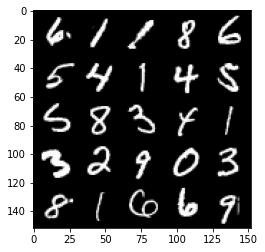

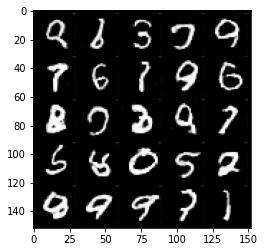

Epoch : 50, step : 47000, mean gen loss : 0.6952010062336919, mean disc loss : 0.6939382806420328
Epoch : 50, step : 47200, mean gen loss : 0.6930652254819868, mean disc loss : 0.693836713731289
Epoch : 50, step : 47400, mean gen loss : 0.6941488477587705, mean disc loss : 0.6937259510159496
Epoch : 50, step : 47600, mean gen loss : 0.6937070658802981, mean disc loss : 0.6937757849693298
Epoch : 50, step : 47800, mean gen loss : 0.6945665687322616, mean disc loss : 0.6937443855404859


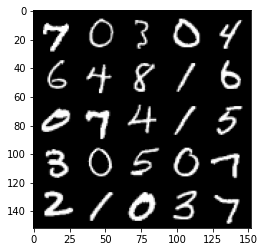

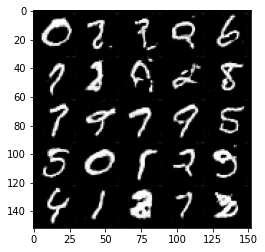

Epoch : 51, step : 48000, mean gen loss : 0.6945206874608991, mean disc loss : 0.6936671513319015
Epoch : 51, step : 48200, mean gen loss : 0.6956102538108829, mean disc loss : 0.6937722429633139
Epoch : 51, step : 48400, mean gen loss : 0.693148317635059, mean disc loss : 0.6945039379596708
Epoch : 51, step : 48600, mean gen loss : 0.6939921528100967, mean disc loss : 0.6941831201314926


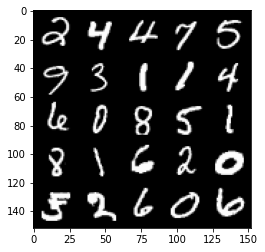

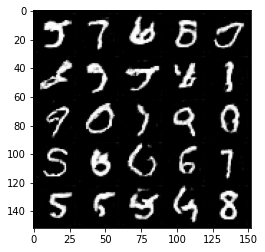

Epoch : 52, step : 48800, mean gen loss : 0.6928462108969685, mean disc loss : 0.6939696499705313
Epoch : 52, step : 49000, mean gen loss : 0.6946439215540885, mean disc loss : 0.6936095118522645
Epoch : 52, step : 49200, mean gen loss : 0.6944356146454812, mean disc loss : 0.6936133345961573
Epoch : 52, step : 49400, mean gen loss : 0.6926941278576847, mean disc loss : 0.6937079396843907
Epoch : 52, step : 49600, mean gen loss : 0.6942365807294848, mean disc loss : 0.6937220519781114


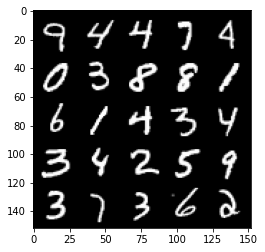

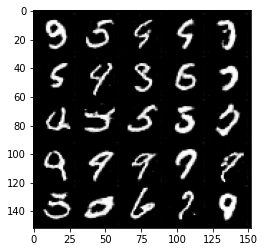

Epoch : 53, step : 49800, mean gen loss : 0.6945124650001528, mean disc loss : 0.6939420202374453
Epoch : 53, step : 50000, mean gen loss : 0.6944717341661456, mean disc loss : 0.693958605229855
Epoch : 53, step : 50200, mean gen loss : 0.6941718420386317, mean disc loss : 0.6941493499279018
Epoch : 53, step : 50400, mean gen loss : 0.6940392720699313, mean disc loss : 0.6939128959178923
Epoch : 53, step : 50600, mean gen loss : 0.693728991448879, mean disc loss : 0.6938424089550974


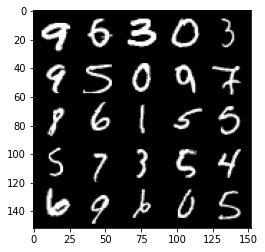

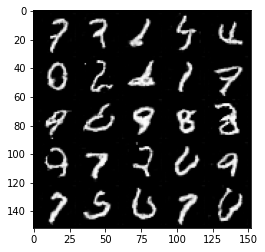

Epoch : 54, step : 50800, mean gen loss : 0.6941794884204865, mean disc loss : 0.6938664183020591
Epoch : 54, step : 51000, mean gen loss : 0.6940741574764252, mean disc loss : 0.693775336742401
Epoch : 54, step : 51200, mean gen loss : 0.6928847828507424, mean disc loss : 0.6937647753953936
Epoch : 54, step : 51400, mean gen loss : 0.6925829687714576, mean disc loss : 0.693749244213104


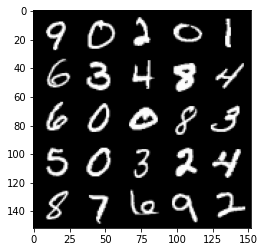

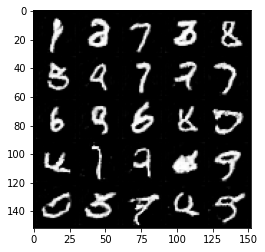

Epoch : 55, step : 51600, mean gen loss : 0.6940839117765428, mean disc loss : 0.6938572281599047
Epoch : 55, step : 51800, mean gen loss : 0.6942403686046604, mean disc loss : 0.693903115391731
Epoch : 55, step : 52000, mean gen loss : 0.693427059948444, mean disc loss : 0.693929413557053
Epoch : 55, step : 52200, mean gen loss : 0.6941666626930234, mean disc loss : 0.693793990910053
Epoch : 55, step : 52400, mean gen loss : 0.6938616421818732, mean disc loss : 0.6938062810897825


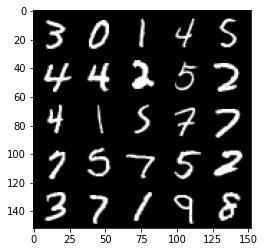

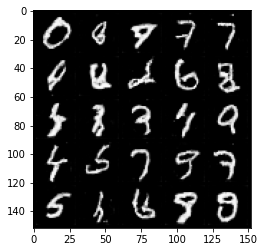

Epoch : 56, step : 52600, mean gen loss : 0.6941353935003278, mean disc loss : 0.6937905931472778
Epoch : 56, step : 52800, mean gen loss : 0.6927992081642151, mean disc loss : 0.6936859357357023
Epoch : 56, step : 53000, mean gen loss : 0.6932255789637561, mean disc loss : 0.6937193042039868
Epoch : 56, step : 53200, mean gen loss : 0.6938684830069545, mean disc loss : 0.69370753467083
Epoch : 56, step : 53400, mean gen loss : 0.6935075944662099, mean disc loss : 0.6937925091385847


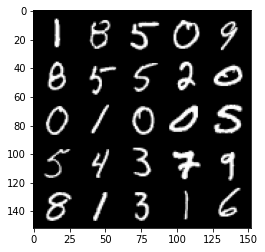

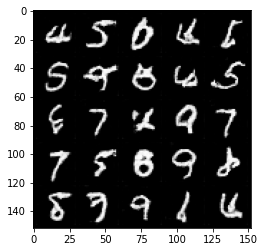

Epoch : 57, step : 53600, mean gen loss : 0.6944977214932444, mean disc loss : 0.693783876299858
Epoch : 57, step : 53800, mean gen loss : 0.6933680140972133, mean disc loss : 0.693622595667839
Epoch : 57, step : 54000, mean gen loss : 0.6935819008946421, mean disc loss : 0.6936093139648437
Epoch : 57, step : 54200, mean gen loss : 0.694585862159729, mean disc loss : 0.6938267290592193
Epoch : 57, step : 54400, mean gen loss : 0.6932340642809863, mean disc loss : 0.6937650531530378


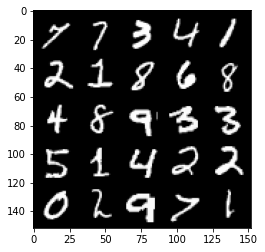

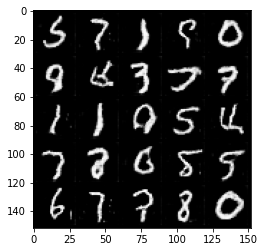

Epoch : 58, step : 54600, mean gen loss : 0.6948165521025658, mean disc loss : 0.693770726919174
Epoch : 58, step : 54800, mean gen loss : 0.6938946509361266, mean disc loss : 0.6936474451422695
Epoch : 58, step : 55000, mean gen loss : 0.6929033794999128, mean disc loss : 0.6937662741541866
Epoch : 58, step : 55200, mean gen loss : 0.6944780024886131, mean disc loss : 0.6936221167445181


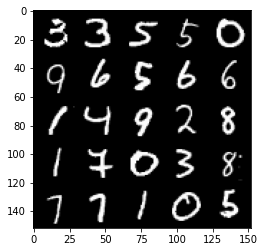

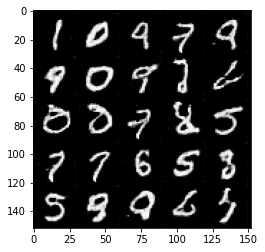

Epoch : 59, step : 55400, mean gen loss : 0.6935061559081078, mean disc loss : 0.6937575533986091
Epoch : 59, step : 55600, mean gen loss : 0.6940022516250609, mean disc loss : 0.6936152538657189
Epoch : 59, step : 55800, mean gen loss : 0.6928108450770379, mean disc loss : 0.6936365440487862
Epoch : 59, step : 56000, mean gen loss : 0.6939806273579601, mean disc loss : 0.6937571272253992
Epoch : 59, step : 56200, mean gen loss : 0.6938753485679631, mean disc loss : 0.6936183714866639


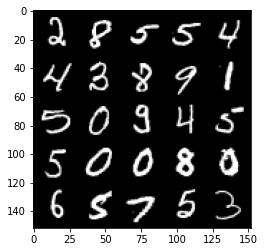

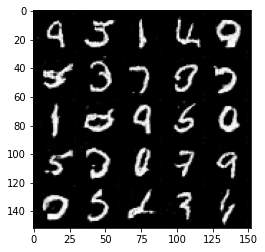

Epoch : 60, step : 56400, mean gen loss : 0.6935864767432215, mean disc loss : 0.6936734691262247
Epoch : 60, step : 56600, mean gen loss : 0.6935263970494271, mean disc loss : 0.6936402028799056
Epoch : 60, step : 56800, mean gen loss : 0.693746739327908, mean disc loss : 0.693578501045704
Epoch : 60, step : 57000, mean gen loss : 0.6926512551307678, mean disc loss : 0.6936251121759412
Epoch : 60, step : 57200, mean gen loss : 0.6943877872824664, mean disc loss : 0.6935237565636632


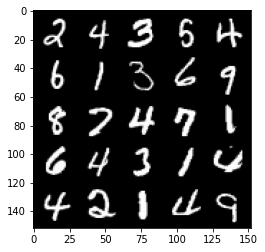

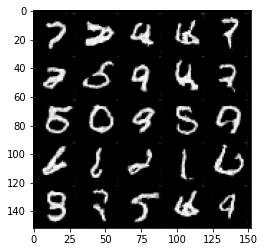

Epoch : 61, step : 57400, mean gen loss : 0.6932694497704506, mean disc loss : 0.693647418618202
Epoch : 61, step : 57600, mean gen loss : 0.693445639908314, mean disc loss : 0.693570508658886
Epoch : 61, step : 57800, mean gen loss : 0.6938085937499999, mean disc loss : 0.6936717280745511
Epoch : 61, step : 58000, mean gen loss : 0.693899472057819, mean disc loss : 0.6935274183750154


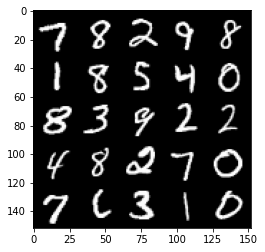

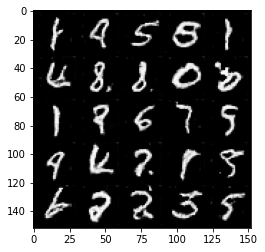

Epoch : 62, step : 58200, mean gen loss : 0.6935229218006133, mean disc loss : 0.6935651075839994
Epoch : 62, step : 58400, mean gen loss : 0.6932382571697236, mean disc loss : 0.6936515361070629
Epoch : 62, step : 58600, mean gen loss : 0.6944410991668702, mean disc loss : 0.6936213076114656
Epoch : 62, step : 58800, mean gen loss : 0.6930847555398942, mean disc loss : 0.6937390190362933
Epoch : 62, step : 59000, mean gen loss : 0.6933181455731391, mean disc loss : 0.6934932574629777


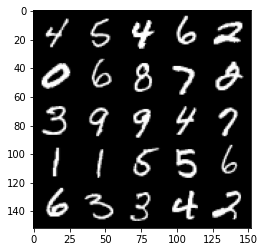

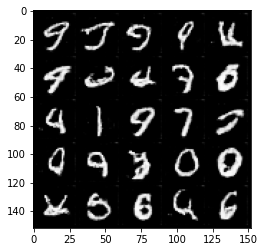

Epoch : 63, step : 59200, mean gen loss : 0.6934644469618799, mean disc loss : 0.6935970544815064
Epoch : 63, step : 59400, mean gen loss : 0.6937385508418081, mean disc loss : 0.6935540258884431
Epoch : 63, step : 59600, mean gen loss : 0.6930653503537184, mean disc loss : 0.6936073529720304
Epoch : 63, step : 59800, mean gen loss : 0.6940810000896456, mean disc loss : 0.6934820520877842
Epoch : 63, step : 60000, mean gen loss : 0.6939932960271833, mean disc loss : 0.693742927014828


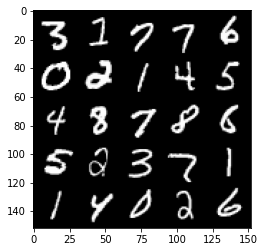

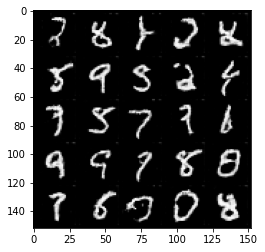

Epoch : 64, step : 60200, mean gen loss : 0.6936976647377011, mean disc loss : 0.6934432968497279
Epoch : 64, step : 60400, mean gen loss : 0.6934580051898956, mean disc loss : 0.6935354697704315
Epoch : 64, step : 60600, mean gen loss : 0.6942232444882392, mean disc loss : 0.6935473421216014
Epoch : 64, step : 60800, mean gen loss : 0.694327883124351, mean disc loss : 0.6936233434081072


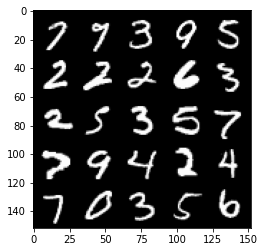

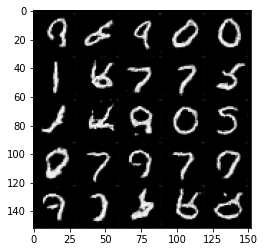

Epoch : 65, step : 61000, mean gen loss : 0.6927812281250953, mean disc loss : 0.6934029451012617
Epoch : 65, step : 61200, mean gen loss : 0.6950318178534508, mean disc loss : 0.6936615288257599
Epoch : 65, step : 61400, mean gen loss : 0.692880019247532, mean disc loss : 0.6935132625699042
Epoch : 65, step : 61600, mean gen loss : 0.6946632239222523, mean disc loss : 0.693491026461124
Epoch : 65, step : 61800, mean gen loss : 0.6928071886301042, mean disc loss : 0.6935431200265888


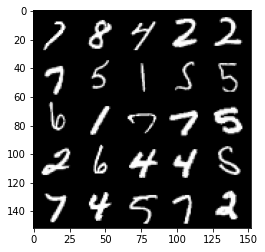

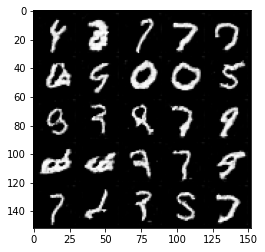

Epoch : 66, step : 62000, mean gen loss : 0.6930237621068959, mean disc loss : 0.6934847596287721
Epoch : 66, step : 62200, mean gen loss : 0.6934137904644013, mean disc loss : 0.6934417772293089
Epoch : 66, step : 62400, mean gen loss : 0.6929089245200154, mean disc loss : 0.6935360625386238
Epoch : 66, step : 62600, mean gen loss : 0.6944007444381712, mean disc loss : 0.6935149720311162
Epoch : 66, step : 62800, mean gen loss : 0.6932561957836147, mean disc loss : 0.6934997868537903


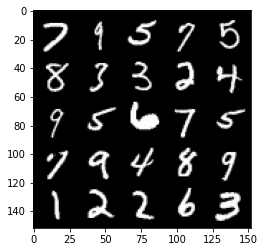

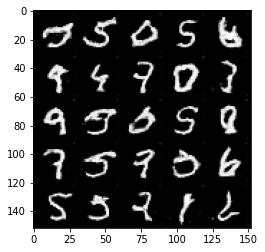

Epoch : 67, step : 63000, mean gen loss : 0.6936183762550352, mean disc loss : 0.6933936154842376
Epoch : 67, step : 63200, mean gen loss : 0.6936731481552129, mean disc loss : 0.6936230388283735
Epoch : 67, step : 63400, mean gen loss : 0.693845258057117, mean disc loss : 0.6934845533967019
Epoch : 67, step : 63600, mean gen loss : 0.6931971344351767, mean disc loss : 0.6934753236174582


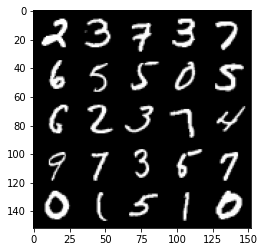

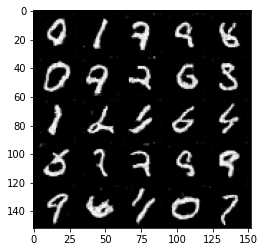

Epoch : 68, step : 63800, mean gen loss : 0.6937974262237552, mean disc loss : 0.6934369719028474
Epoch : 68, step : 64000, mean gen loss : 0.6938164517283437, mean disc loss : 0.6934595090150834
Epoch : 68, step : 64200, mean gen loss : 0.6931168711185458, mean disc loss : 0.6935997241735462
Epoch : 68, step : 64400, mean gen loss : 0.6937727528810501, mean disc loss : 0.6934170123934746
Epoch : 68, step : 64600, mean gen loss : 0.6939267483353615, mean disc loss : 0.6933677983283996


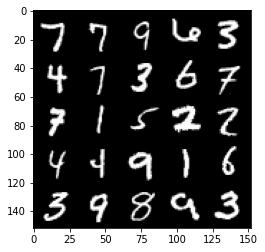

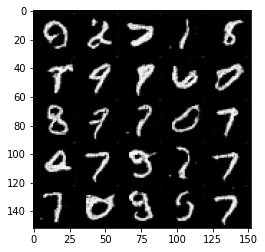

Epoch : 69, step : 64800, mean gen loss : 0.6932026791572572, mean disc loss : 0.6934250625967978
Epoch : 69, step : 65000, mean gen loss : 0.6941105535626411, mean disc loss : 0.6935362127423286
Epoch : 69, step : 65200, mean gen loss : 0.6925918936729424, mean disc loss : 0.6934828659892086
Epoch : 69, step : 65400, mean gen loss : 0.6940716043114662, mean disc loss : 0.6933990284800533
Epoch : 69, step : 65600, mean gen loss : 0.6932829853892329, mean disc loss : 0.6934554874897005


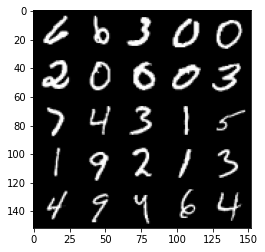

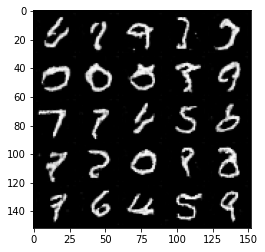

Epoch : 70, step : 65800, mean gen loss : 0.6928329366445545, mean disc loss : 0.6933257091045381
Epoch : 70, step : 66000, mean gen loss : 0.6939714747667312, mean disc loss : 0.6934794393181801
Epoch : 70, step : 66200, mean gen loss : 0.6934303292632104, mean disc loss : 0.6933779320120812
Epoch : 70, step : 66400, mean gen loss : 0.6932095229625698, mean disc loss : 0.6933723786473276


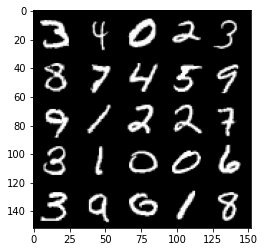

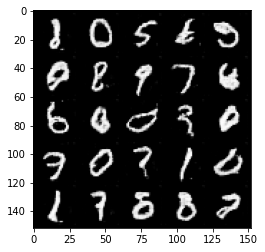

Epoch : 71, step : 66600, mean gen loss : 0.6941367539763452, mean disc loss : 0.6934370723366736
Epoch : 71, step : 66800, mean gen loss : 0.6933646509051321, mean disc loss : 0.6934383511543274
Epoch : 71, step : 67000, mean gen loss : 0.6938903376460078, mean disc loss : 0.6934441885352131
Epoch : 71, step : 67200, mean gen loss : 0.6934619989991191, mean disc loss : 0.6934399959445
Epoch : 71, step : 67400, mean gen loss : 0.6926260963082318, mean disc loss : 0.6935441705584525


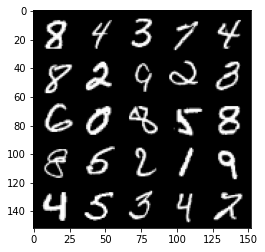

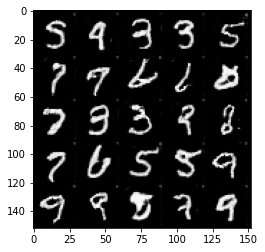

Epoch : 72, step : 67600, mean gen loss : 0.6938329979777337, mean disc loss : 0.6936476919054981
Epoch : 72, step : 67800, mean gen loss : 0.6935858792066574, mean disc loss : 0.6933925095200536
Epoch : 72, step : 68000, mean gen loss : 0.6927433338761332, mean disc loss : 0.6934498506784439
Epoch : 72, step : 68200, mean gen loss : 0.6939438444375996, mean disc loss : 0.6933995568752288
Epoch : 72, step : 68400, mean gen loss : 0.6927597674727443, mean disc loss : 0.6934549555182459


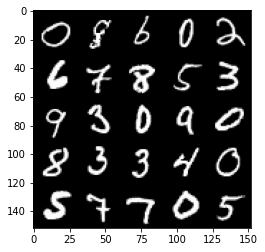

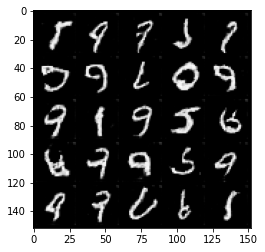

Epoch : 73, step : 68600, mean gen loss : 0.6942018064856529, mean disc loss : 0.6934699493646622
Epoch : 73, step : 68800, mean gen loss : 0.6931655150651934, mean disc loss : 0.6933970579504968
Epoch : 73, step : 69000, mean gen loss : 0.6935701486468319, mean disc loss : 0.693427831530571
Epoch : 73, step : 69200, mean gen loss : 0.6932817327976225, mean disc loss : 0.693386664688587
Epoch : 73, step : 69400, mean gen loss : 0.6930917745828628, mean disc loss : 0.6934232422709462


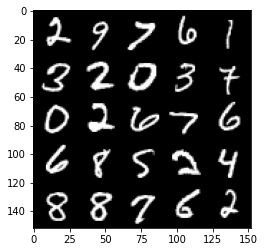

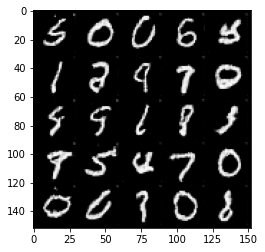

Epoch : 74, step : 69600, mean gen loss : 0.694193912446499, mean disc loss : 0.6934026995301247
Epoch : 74, step : 69800, mean gen loss : 0.6931519883871076, mean disc loss : 0.6933584481477735
Epoch : 74, step : 70000, mean gen loss : 0.6942991289496422, mean disc loss : 0.6934510731697081
Epoch : 74, step : 70200, mean gen loss : 0.6926997992396351, mean disc loss : 0.6933831945061686


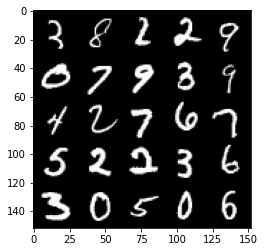

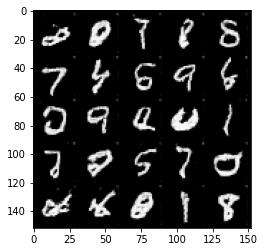

Epoch : 75, step : 70400, mean gen loss : 0.6937842005491256, mean disc loss : 0.6934407639503478
Epoch : 75, step : 70600, mean gen loss : 0.6930627566576002, mean disc loss : 0.6933310079574583
Epoch : 75, step : 70800, mean gen loss : 0.6934374579787257, mean disc loss : 0.6933791467547415
Epoch : 75, step : 71000, mean gen loss : 0.6934643965959547, mean disc loss : 0.6934256169199942
Epoch : 75, step : 71200, mean gen loss : 0.6928192061185838, mean disc loss : 0.6933586379885674


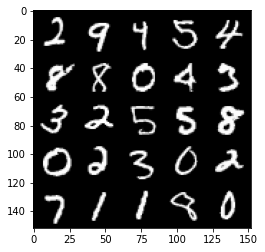

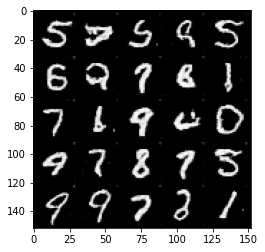

Epoch : 76, step : 71400, mean gen loss : 0.6935327669978139, mean disc loss : 0.6934050786495207
Epoch : 76, step : 71600, mean gen loss : 0.6937319383025173, mean disc loss : 0.6934018519520763
Epoch : 76, step : 71800, mean gen loss : 0.6933392921090126, mean disc loss : 0.6933587479591371
Epoch : 76, step : 72000, mean gen loss : 0.6927533069252966, mean disc loss : 0.6933496057987214
Epoch : 76, step : 72200, mean gen loss : 0.6935841983556756, mean disc loss : 0.6934223797917367


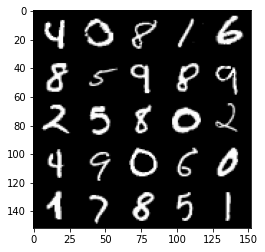

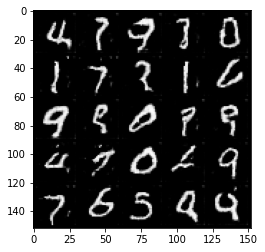

Epoch : 77, step : 72400, mean gen loss : 0.693164371550083, mean disc loss : 0.6933964994549753
Epoch : 77, step : 72600, mean gen loss : 0.693640831708908, mean disc loss : 0.6934860968589787
Epoch : 77, step : 72800, mean gen loss : 0.6933989953994749, mean disc loss : 0.6934210863709455
Epoch : 77, step : 73000, mean gen loss : 0.6929067316651346, mean disc loss : 0.693378250896931


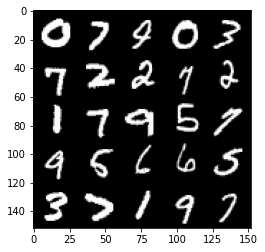

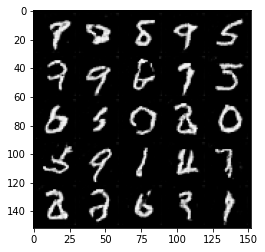

Epoch : 78, step : 73200, mean gen loss : 0.6949607637524607, mean disc loss : 0.6933808618783951
Epoch : 78, step : 73400, mean gen loss : 0.6927151873707773, mean disc loss : 0.6934193566441536
Epoch : 78, step : 73600, mean gen loss : 0.6934424605965612, mean disc loss : 0.6934654411673544
Epoch : 78, step : 73800, mean gen loss : 0.6935111302137371, mean disc loss : 0.6933591645956042
Epoch : 78, step : 74000, mean gen loss : 0.693038493394852, mean disc loss : 0.6934722545742988


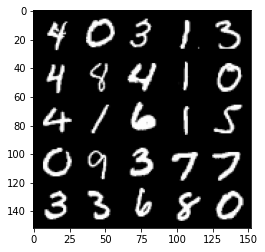

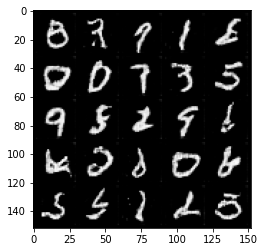

Epoch : 79, step : 74200, mean gen loss : 0.6937624177336693, mean disc loss : 0.6933664545416833
Epoch : 79, step : 74400, mean gen loss : 0.6935392963886264, mean disc loss : 0.6933392956852914
Epoch : 79, step : 74600, mean gen loss : 0.6923971742391584, mean disc loss : 0.6933707091212272
Epoch : 79, step : 74800, mean gen loss : 0.6935783687233923, mean disc loss : 0.693394878208637
Epoch : 79, step : 75000, mean gen loss : 0.6929197832942003, mean disc loss : 0.6936672055721288


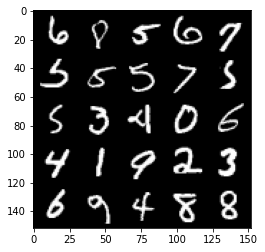

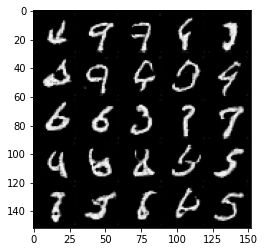

KeyboardInterrupt: 

In [15]:
mean_gen_loss = 0
mean_disc_loss = 0
step_size = 200
current_step = 0
eval_step_size = 200
for epoch in range(epochs):
    for index, (real, label) in enumerate(loader):
        # generate the discriminator classification on the real and fake images
        current_step += 1
        batch_size = real.shape[0]
        disc_opt.zero_grad()
        real = real.to(device)
        disc_real_pred = disc(real)
        noise = gen.sample_noise(batch_size, z_dim, device)
        noise = noise.view(batch_size, z_dim, 1, 1)
        fake = gen(noise) # dimension -> batch_size x im_channels x height x width
        
        disc_fake_pred = disc(fake.detach()) # gradients shouldn't backpropagate to the generator
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss)/2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        gen_opt.zero_grad()
        noise = gen.sample_noise(batch_size, z_dim, device)
        noise = noise.view(batch_size, z_dim, 1, 1)
        fake = gen(noise)
        disc_fake_pred = disc(fake)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        
        mean_disc_loss += disc_loss.item() / step_size
        mean_gen_loss += gen_loss.item() / step_size
        
        if current_step % step_size == 0:
            print(f'Epoch : {epoch}, step : {current_step}, mean gen loss : {mean_gen_loss}, mean disc loss : {mean_disc_loss}')
            mean_disc_loss = 0
            mean_gen_loss = 0
    
    show_tensor_images(real)
    show_tensor_images(fake)

In [ ]:
# The images in the VQVAE2 dataset are of the dimension -> (batch_size x 3 x )